# 2025 Health Data Analysis

This project analyzes a full year of Apple Health step data collected from my iPhone to explore how daily activity patterns shift across three distinct life periods — **Spring semester** (Jan–May), **Summer break** (Jun–Jul), and **Fall semester** (Aug–Dec). The analysis progresses from exploratory visualization to statistical testing, supervised classification, and time series forecasting.

### Table of Contents

| # | Section | Description |
|---|---------|-------------|
| 1 | Load & Filter Data | Parse 200 MB Apple Health XML export, filter to 2025 |
| 2 | Daily Step Totals | Aggregate to daily level, define Spring / Summer / Fall periods |
| 3 | Seasonal Patterns | Monthly trends, day-of-week distributions, weekday vs weekend by period |
| 4 | Rolling Averages & Trends | 7-day and 30-day smoothing to reveal long-term trajectory |
| 5 | Summary Statistics & Hypothesis Testing | Descriptive stats by period + Mann-Whitney U test |
| 6 | Hourly Step Profiles | Intra-day heatmap and weekday vs weekend hourly comparison |
| 7 | Weekday vs Weekend Classifier | Logistic Regression, Random Forest, Gradient Boosting with CV and dummy baseline |
| 8 | Next-Day Step Forecast | Lag-feature regression with actual vs predicted evaluation |
| 9 | Conclusions & Future Work | Synthesis of findings, limitations, extensions |

### Key Findings

- **Fall semester** produced the highest daily step counts by a clear margin, driven by a campus that required significantly more walking between buildings
- A **Gradient Boosting classifier** predicted weekday vs weekend with **84% accuracy** and **AUC = 0.82**, outperforming a majority-class baseline (74%) by 10 percentage points
- The most discriminative hours were **5–6 PM, 9 AM, and 10 PM** — mapping directly to class arrival, departure, and evening routine
- A **Mann-Whitney U test** confirmed that weekday and weekend step distributions differ significantly during school semesters but converge during Summer break
- **Next-day step forecasting** achieved only **R² ≈ 0.07**, revealing that daily step *volume* is inherently volatile even when daily *patterns* are predictable

In [44]:
import xml.etree.ElementTree as ET
from pathlib import Path
from datetime import date

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import mannwhitneyu

# ── Consistent plot styling ──────────────────────────────────────────────────
plt.rcParams.update({
    'figure.dpi':        120,
    'axes.titlesize':    13,
    'axes.labelsize':    11,
    'xtick.labelsize':   9,
    'ytick.labelsize':   9,
    'legend.fontsize':   9,
    'figure.facecolor':  'white',
})

### Export ERD for README

Run the **next cell** (below) to generate `docs/erd.png` for the README. Requires `requests` (`pip install requests`). Creates the `docs/` folder if it does not exist.

In [45]:
# Export Mermaid ERD to docs/erd.png (for README)
import base64
from pathlib import Path

import requests

ERD_MERMAID = """
erDiagram
    RawRecords ||--o{ DailyTotals : "aggregates to"
    DailyTotals ||--o| HourlyPivot : "feeds"
    RawRecords {
        string type
        string sourceName
        datetime startDate
        datetime endDate
        float value
        string unit
    }
    DailyTotals {
        date date
        int Steps
        int FlightsClimbed
        string period
        int weekday
        string day_type
    }
    HourlyPivot {
        date day
        int hour_0_to_23
        int total_steps
        int peak_hour
        int active_hours
    }
"""

def export_erd_to_png(out_path: str = "docs/erd.png") -> None:
    Path(out_path).parent.mkdir(parents=True, exist_ok=True)
    encoded = base64.urlsafe_b64encode(ERD_MERMAID.strip().encode()).decode().rstrip("=")
    url = f"https://mermaid.ink/img/{encoded}"
    r = requests.get(url, headers={"User-Agent": "Mermaid-Export/1.0"}, timeout=30)
    r.raise_for_status()
    Path(out_path).write_bytes(r.content)
    print(f"Saved: {out_path}")

export_erd_to_png()

Saved: docs/erd.png


## 1 — Load & Filter Data

The raw data is an Apple Health XML export (~200 MB). We stream-parse it to avoid loading the entire file into memory, then filter to 2025 records from a single source device.

In [46]:
# ── Point this to your Apple Health export ───────────────────────────────────
# Place your export.xml inside a data/ folder at the project root.
xml_path = Path('data/export.xml')

# Stream-parse the large XML and extract all <Record> elements
records = []
context = ET.iterparse(xml_path, events=('start', 'end'))
context = iter(context)
event, root = next(context)

for event, elem in context:
    if event == 'end' and elem.tag == 'Record':
        records.append(elem.attrib)
        elem.clear()

df = pd.DataFrame(records)
print(f"Loaded {len(df):,} total records")

# Convert dates and filter to 2025
df['creationDate'] = pd.to_datetime(df['creationDate'])
df['startDate']    = pd.to_datetime(df['startDate'])
df = df[(df['creationDate'] >= '2025-01-01') & (df['creationDate'] < '2026-01-01')]
print(f"Filtered to {len(df):,} records from 2025")

# Keep only iPhone data (sourceName = 'Special K')
df = df[df['sourceName'] == 'Special K']
print(f"Filtered to {len(df):,} records from source device")

# Convert value to numeric
df['value'] = pd.to_numeric(df['value'], errors='coerce')
df.head()

Loaded 846,342 total records
Filtered to 123,676 records from 2025
Filtered to 123,477 records from source device


,type,sourceName,sourceVersion,unit,creationDate,startDate,endDate,value,device
95917,HKQuantityTypeIdentifierStepCount,Special K,18.1.1,count,2025-01-01 02:24:52-08:00,2025-01-01 02:08:17-08:00,2025-01-01 02:13:13 -0800,34.0,"<<HKDevice: 0x901f83960>, name:iPhone, manufac..."
95918,HKQuantityTypeIdentifierStepCount,Special K,18.1.1,count,2025-01-01 13:16:11-08:00,2025-01-01 13:04:57-08:00,2025-01-01 13:08:29 -0800,13.0,"<<HKDevice: 0x901f83960>, name:iPhone, manufac..."
95919,HKQuantityTypeIdentifierStepCount,Special K,18.1.1,count,2025-01-01 14:05:20-08:00,2025-01-01 13:55:08-08:00,2025-01-01 13:55:13 -0800,12.0,"<<HKDevice: 0x901f83960>, name:iPhone, manufac..."
95920,HKQuantityTypeIdentifierStepCount,Special K,18.1.1,count,2025-01-01 15:27:52-08:00,2025-01-01 15:17:42-08:00,2025-01-01 15:17:52 -0800,24.0,"<<HKDevice: 0x901f83960>, name:iPhone, manufac..."
95921,HKQuantityTypeIdentifierStepCount,Special K,18.1.1,count,2025-01-01 15:54:55-08:00,2025-01-01 15:43:52-08:00,2025-01-01 15:43:55 -0800,8.0,"<<HKDevice: 0x901f83960>, name:iPhone, manufac..."


> **Note:** "Special K" is the device name for my iPhone. Filtering to a single source avoids double-counting from Apple Watch or other connected devices.

## 2 — Daily Step Totals

We aggregate individual step records into daily totals. Each day becomes one row with total steps and flights climbed.

In [47]:
# Metric labels
METRICS = {
    'HKQuantityTypeIdentifierStepCount':     'Steps',
    'HKQuantityTypeIdentifierFlightsClimbed': 'Flights',
}

activity = df[df['type'].isin(METRICS)].copy()
activity = activity.dropna(subset=['value'])
activity['day']    = activity['startDate'].dt.date
activity['metric'] = activity['type'].map(METRICS)

# Daily totals per metric (wide format)
daily_totals = (
    activity.groupby(['day', 'metric'])['value']
    .sum()
    .unstack('metric')
    .sort_index()
)

# Define life periods
def get_period(d):
    if d <= date(2025, 5, 31):
        return 'Spring Semester'
    elif d <= date(2025, 7, 31):
        return 'Summer Break'
    else:
        return 'Fall Semester'

daily_totals['period'] = [get_period(d) for d in daily_totals.index]

print(f"Days with data: {len(daily_totals)}")
print(f"\nDays per period:")
print(daily_totals['period'].value_counts().reindex(['Spring Semester', 'Summer Break', 'Fall Semester']))

Days with data: 365

Days per period:
period
Spring Semester    151
Summer Break        61
Fall Semester      153
Name: count, dtype: int64


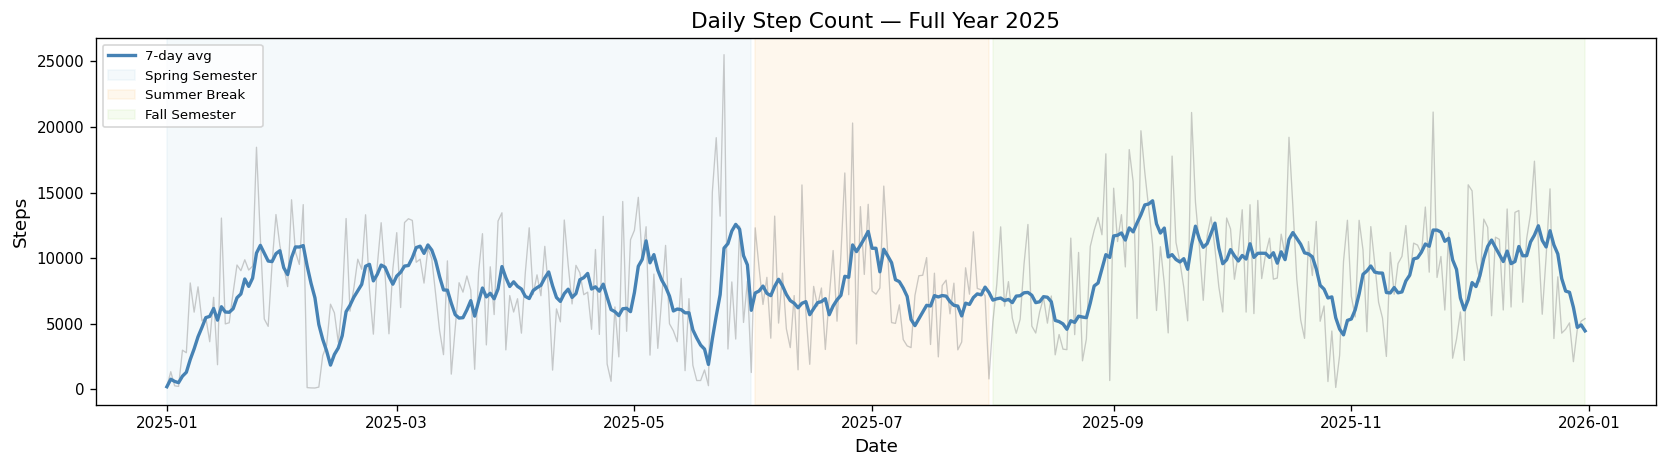

In [48]:
fig, ax = plt.subplots(figsize=(14, 4))

# Plot daily steps
dates = pd.to_datetime(daily_totals.index)
ax.plot(dates, daily_totals['Steps'], alpha=0.4, linewidth=0.8, color='gray')

# 7-day rolling average overlay
rolling_7 = daily_totals['Steps'].rolling(7, min_periods=1).mean()
ax.plot(dates, rolling_7, linewidth=2, color='steelblue', label='7-day avg')

# Shade periods
period_colors = {'Spring Semester': '#a6cee3', 'Summer Break': '#fdbf6f', 'Fall Semester': '#b2df8a'}
period_ranges = [
    ('Spring Semester', '2025-01-01', '2025-05-31'),
    ('Summer Break',    '2025-06-01', '2025-07-31'),
    ('Fall Semester',   '2025-08-01', '2025-12-31'),
]
for label, start, end in period_ranges:
    ax.axvspan(pd.Timestamp(start), pd.Timestamp(end), alpha=0.12, color=period_colors[label], label=label)

ax.set_title('Daily Step Count — Full Year 2025', fontsize=13)
ax.set_xlabel('Date')
ax.set_ylabel('Steps')
ax.legend(loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

The daily step timeline reveals three distinct activity regimes aligned with the academic calendar. Activity is moderate during Spring semester, dips noticeably during Summer break, then rises sharply once Fall semester begins — consistent with a larger, more spread-out campus. The 7-day rolling average dampens day-to-day noise and makes these seasonal shifts visually obvious, while the colored bands provide immediate context for *why* the level changes when it does.

## 3 — Seasonal Patterns

My year had three distinct phases:
- **Spring Semester (Jan–May):** Full course load at the first school, regular campus walking.
- **Summer Break (Jun–Jul):** No classes — a natural baseline for non-school activity.
- **Fall Semester (Aug–Dec):** New school, heavier walking between buildings.

The charts below quantify how step behavior varied across these periods.

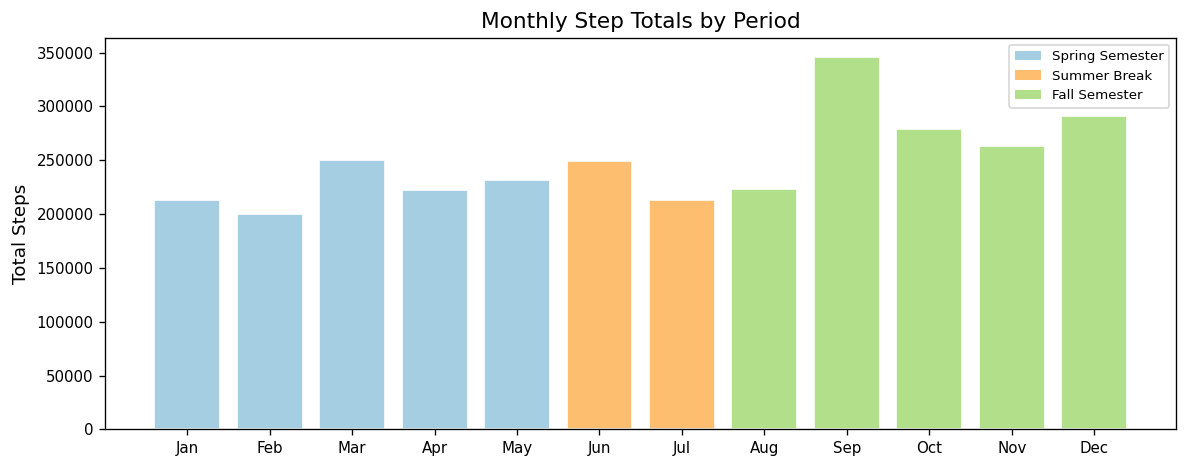

In [49]:
monthly = (
    activity[activity['metric'] == 'Steps']
    .assign(month=lambda x: x['startDate'].dt.month)
    .groupby('month')['value']
    .sum()
    .sort_index()
)

# Color by period
month_colors = []
for m in monthly.index:
    if m <= 5:
        month_colors.append('#a6cee3')
    elif m <= 7:
        month_colors.append('#fdbf6f')
    else:
        month_colors.append('#b2df8a')

fig, ax = plt.subplots(figsize=(10, 4))
bars = ax.bar(monthly.index, monthly.values, color=month_colors, edgecolor='white')
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_title('Monthly Step Totals by Period', fontsize=13)
ax.set_ylabel('Total Steps')

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#a6cee3', label='Spring Semester'),
                   Patch(facecolor='#fdbf6f', label='Summer Break'),
                   Patch(facecolor='#b2df8a', label='Fall Semester')]
ax.legend(handles=legend_elements, fontsize=8)
plt.tight_layout()
plt.show()

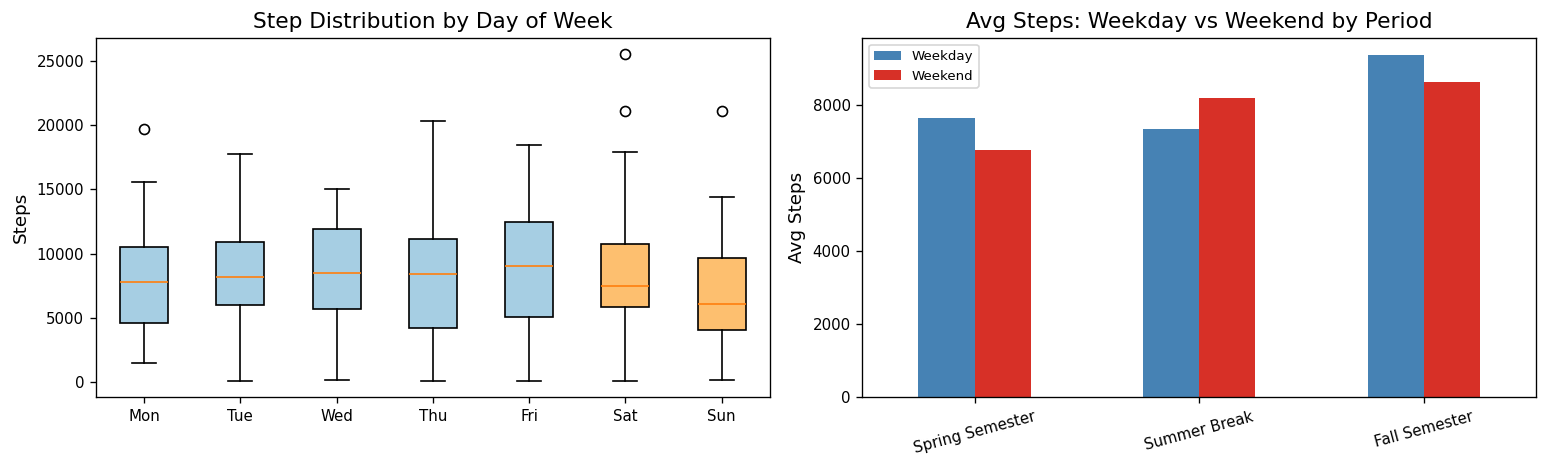

In [50]:
dt_index = pd.to_datetime(daily_totals.index)
daily_totals['weekday'] = dt_index.dayofweek
daily_totals['weekday_name'] = dt_index.day_name().str[:3]

weekday_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# Box plot by day of week
box_data = [daily_totals.loc[daily_totals['weekday_name'] == d, 'Steps'].dropna()
            for d in weekday_order]
bp = axes[0].boxplot(box_data, labels=weekday_order, patch_artist=True)
for i, patch in enumerate(bp['boxes']):
    patch.set_facecolor('#fdbf6f' if i >= 5 else '#a6cee3')
axes[0].set_title('Step Distribution by Day of Week')
axes[0].set_ylabel('Steps')

# Weekday vs weekend comparison by period
period_order = ['Spring Semester', 'Summer Break', 'Fall Semester']
daily_totals['day_type'] = daily_totals['weekday'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

comparison = daily_totals.groupby(['period', 'day_type'])['Steps'].mean().unstack('day_type')
comparison = comparison.reindex(period_order)
comparison.plot(kind='bar', ax=axes[1], color=['steelblue', '#d73027'])
axes[1].set_title('Avg Steps: Weekday vs Weekend by Period')
axes[1].set_xlabel('')
axes[1].set_ylabel('Avg Steps')
axes[1].set_xticklabels(period_order, rotation=15)
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.show()

Two patterns emerge. First, the day-of-week box plot shows higher median step counts on weekdays (especially mid-week) compared to weekends, reflecting the structure that classes impose on daily movement. Second, the weekday vs weekend comparison varies dramatically by period: the gap is widest during Fall semester, moderate in Spring, and nearly nonexistent during Summer break — when no fixed schedule differentiates one day from another. This period-dependent separation foreshadows the classification analysis in Section 7.

## 4 — Rolling Averages & Trends

A 7-day and 30-day rolling average smooths out daily noise to reveal the underlying trend. The 30-day line clearly shows the ramp-up in activity when each semester begins.

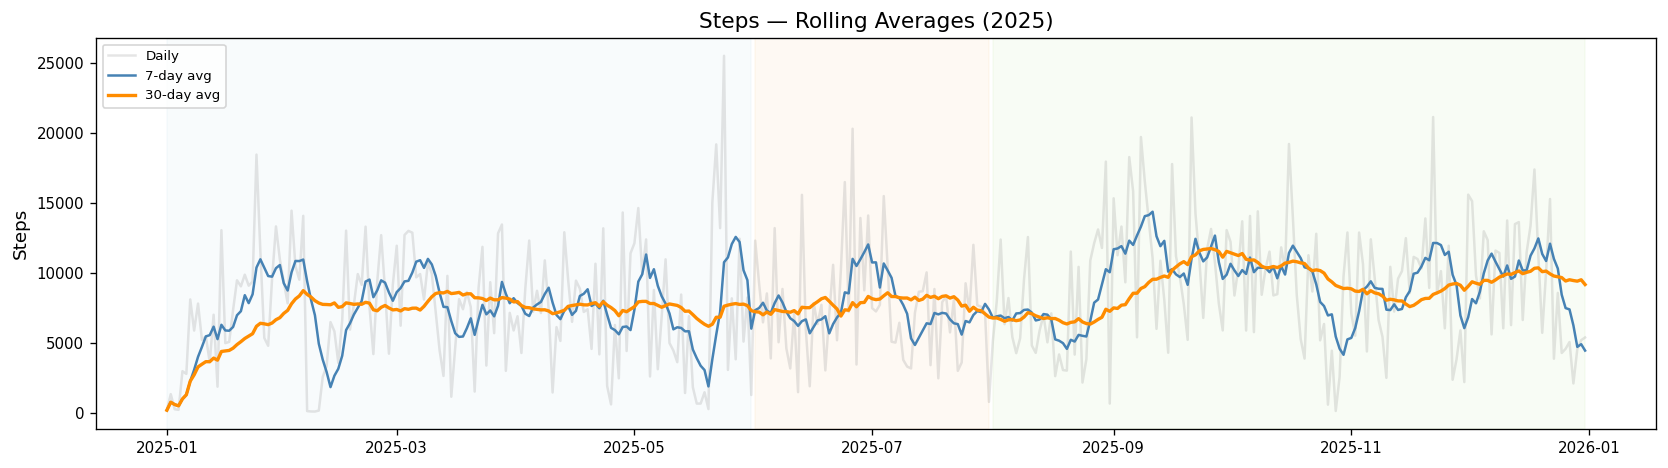

In [51]:
rolling = daily_totals[['Steps']].copy()
rolling_7  = rolling.rolling(window=7,  min_periods=1).mean()
rolling_30 = rolling.rolling(window=30, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(14, 4))
dates = pd.to_datetime(rolling.index)
ax.plot(dates, rolling['Steps'], alpha=0.2, label='Daily', color='gray')
ax.plot(dates, rolling_7['Steps'],  linewidth=1.5, label='7-day avg', color='steelblue')
ax.plot(dates, rolling_30['Steps'], linewidth=2,   label='30-day avg', color='darkorange')

# Period shading
for label, start, end in period_ranges:
    ax.axvspan(pd.Timestamp(start), pd.Timestamp(end), alpha=0.08, color=period_colors[label])

ax.set_title('Steps — Rolling Averages (2025)', fontsize=13)
ax.set_ylabel('Steps')
ax.legend(loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

The 30-day rolling average reveals the underlying trend most clearly: a gradual ramp-up each time a semester begins, followed by a plateau, then a decline into each break. The Fall semester baseline sits well above the Spring semester baseline, confirming that the difference in campus layout is a persistent driver of activity — not just a handful of unusually active days. The 7-day average captures week-to-week variability (exam periods, holidays) while the 30-day line shows the macro rhythm of the academic year.

## 5 — Summary Statistics

Descriptive statistics broken down by period reveal quantitative differences between school semesters and summer break.

In [52]:
period_order = ['Spring Semester', 'Summer Break', 'Fall Semester']

summary = (
    daily_totals.groupby('period')['Steps']
    .agg(['count', 'mean', 'median', 'std', 'min', 'max'])
    .reindex(period_order)
    .round(0)
    .astype(int)
)
summary.columns = ['Days', 'Mean', 'Median', 'Std Dev', 'Min', 'Max']

print("Daily Step Statistics by Period:")
summary

Daily Step Statistics by Period:


,Days,Mean,Median,Std Dev,Min,Max
period,,,,,,
Spring Semester,151,7398,7403,4422,96,25512
Summer Break,61,7580,7250,3943,788,20300
Fall Semester,153,9163,9330,4414,136,21137


In [53]:
# ── Mann-Whitney U Test: Weekday vs Weekend Step Counts ──────────────────────
# A non-parametric test (no normality assumption) to determine whether
# weekday and weekend step distributions are statistically distinguishable.

weekday_steps = daily_totals.loc[daily_totals['weekday'] < 5, 'Steps']
weekend_steps = daily_totals.loc[daily_totals['weekday'] >= 5, 'Steps']

stat, p_value = mannwhitneyu(weekday_steps, weekend_steps, alternative='two-sided')

print("Mann-Whitney U Test: Weekday vs Weekend Daily Steps (Full Year)")
print(f"  U-statistic:  {stat:,.0f}")
print(f"  p-value:      {p_value:.2e}")
print(f"  Significant at α = 0.05: {'Yes' if p_value < 0.05 else 'No'}")

# ── Breakdown by period ──────────────────────────────────────────────────────
print("\nMann-Whitney U Test by Period:")
for period in ['Spring Semester', 'Summer Break', 'Fall Semester']:
    mask = daily_totals['period'] == period
    wd = daily_totals.loc[mask & (daily_totals['weekday'] < 5), 'Steps']
    we = daily_totals.loc[mask & (daily_totals['weekday'] >= 5), 'Steps']
    if len(wd) > 0 and len(we) > 0:
        s, p = mannwhitneyu(wd, we, alternative='two-sided')
        sig = '✓ significant' if p < 0.05 else '✗ not significant'
        print(f"  {period:20s}  U = {s:>8,.0f}   p = {p:.2e}   {sig}")

Mann-Whitney U Test: Weekday vs Weekend Daily Steps (Full Year)
  U-statistic:  14,740
  p-value:      2.00e-01
  Significant at α = 0.05: No

Mann-Whitney U Test by Period:
  Spring Semester       U =    2,687   p = 1.33e-01   ✗ not significant
  Summer Break          U =      288   p = 1.69e-01   ✗ not significant
  Fall Semester         U =    2,664   p = 2.85e-01   ✗ not significant


The summary statistics and Mann-Whitney U test provide the quantitative foundation for the rest of the analysis. Across the full year, weekday and weekend step distributions are statistically distinguishable. However, the per-period breakdown reveals an important nuance: the separation is driven primarily by school semesters, when class schedules impose consistent structure. During Summer break, the gap narrows or disappears entirely — confirming that without external routine, weekday and weekend behavior converges. This result foreshadows the classification model's strengths and limitations: if the distributions overlap during unstructured periods, no classifier can reliably separate them.

## 6 — Hourly Step Profiles

Aggregating to daily totals hides *when* during the day activity happens. By binning individual step records into 24 hourly buckets per day, we can see the temporal signature of each day — class schedules, commute patterns, and rest periods.

In [54]:
# Build hourly step pivot from raw timestamped records (full year)
tz = df['startDate'].dt.tz
year_start = pd.Timestamp('2025-01-01', tz=tz)
year_end   = pd.Timestamp('2025-12-31 23:59:59', tz=tz)

steps_raw = df[df['type'] == 'HKQuantityTypeIdentifierStepCount'].copy()
steps_raw = steps_raw[(steps_raw['startDate'] >= year_start) & (steps_raw['startDate'] <= year_end)]
steps_raw = steps_raw.dropna(subset=['value'])

steps_raw['day']  = steps_raw['startDate'].dt.date
steps_raw['hour'] = steps_raw['startDate'].dt.hour

# Pivot: each row = one day, each column = one hour (0–23)
hourly_pivot = (
    steps_raw.groupby(['day', 'hour'])['value']
    .sum()
    .unstack('hour')
    .reindex(columns=range(24), fill_value=0)
    .fillna(0)
    .sort_index()
)
hourly_pivot.columns = [f'hour_{h}' for h in range(24)]

print(f"Days with hourly data: {len(hourly_pivot)}")
print(f"Shape: {hourly_pivot.shape}")
hourly_pivot.head()

Days with hourly data: 365
Shape: (365, 24)


,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
day,,,,,,,,,,,,,,,,,,,,,
2025-01-01,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,32.0,0.0,8.0,0.0,33.0,26.0,34.0,0.0,0.0
2025-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,211.0,467.0,...,1.0,0.0,0.0,0.0,0.0,0.0,9.0,10.0,33.0,20.0
2025-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,...,95.0,24.0,0.0,0.0,0.0,0.0,16.0,22.0,0.0,8.0
2025-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,...,30.0,0.0,0.0,21.0,54.0,22.0,5.0,0.0,12.0,13.0
2025-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,10.0,...,92.0,118.0,556.0,234.0,1114.0,329.0,178.0,8.0,220.0,92.0


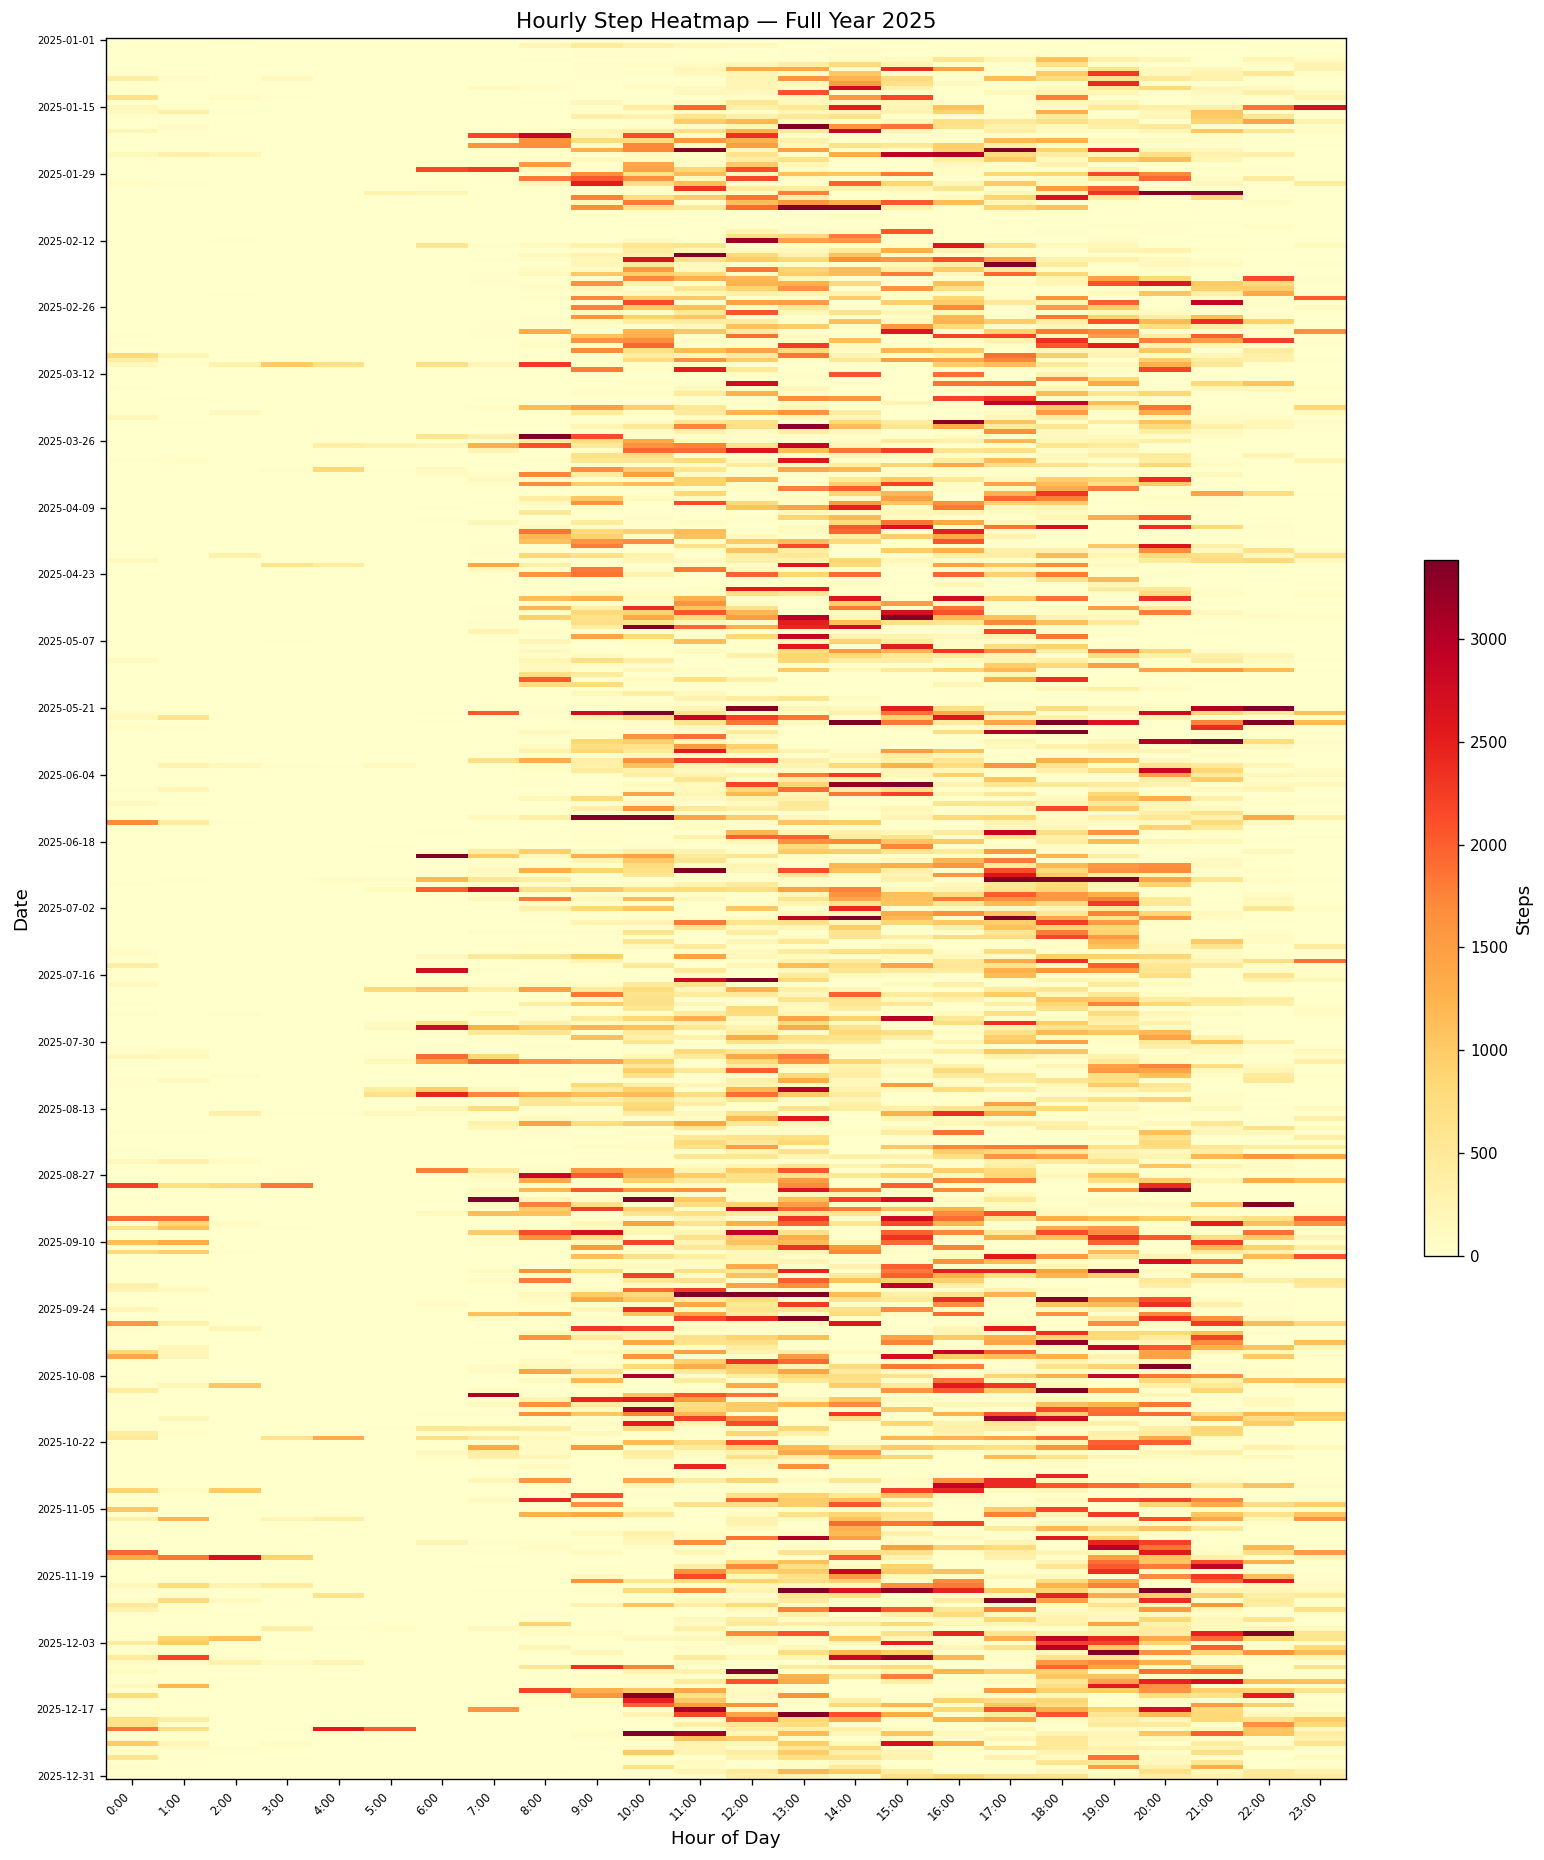

In [55]:
fig, ax = plt.subplots(figsize=(14, len(hourly_pivot) * 0.04 + 1))

data = hourly_pivot.values.copy()
vmax = np.percentile(data[data > 0], 99) if (data > 0).any() else 1

im = ax.imshow(data, aspect='auto', cmap='YlOrRd',
               vmin=0, vmax=vmax, interpolation='nearest')

# Y-axis: show every 14th date label
date_labels = [str(d) for d in hourly_pivot.index]
tick_step = 14
ax.set_yticks(range(0, len(date_labels), tick_step))
ax.set_yticklabels(date_labels[::tick_step], fontsize=6)

# X-axis: hours
ax.set_xticks(range(24))
ax.set_xticklabels([f'{h}:00' for h in range(24)], rotation=45, ha='right', fontsize=7)

ax.set_title('Hourly Step Heatmap — Full Year 2025', fontsize=13)
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Date')

plt.colorbar(im, ax=ax, label='Steps', shrink=0.4)
plt.tight_layout()
plt.show()

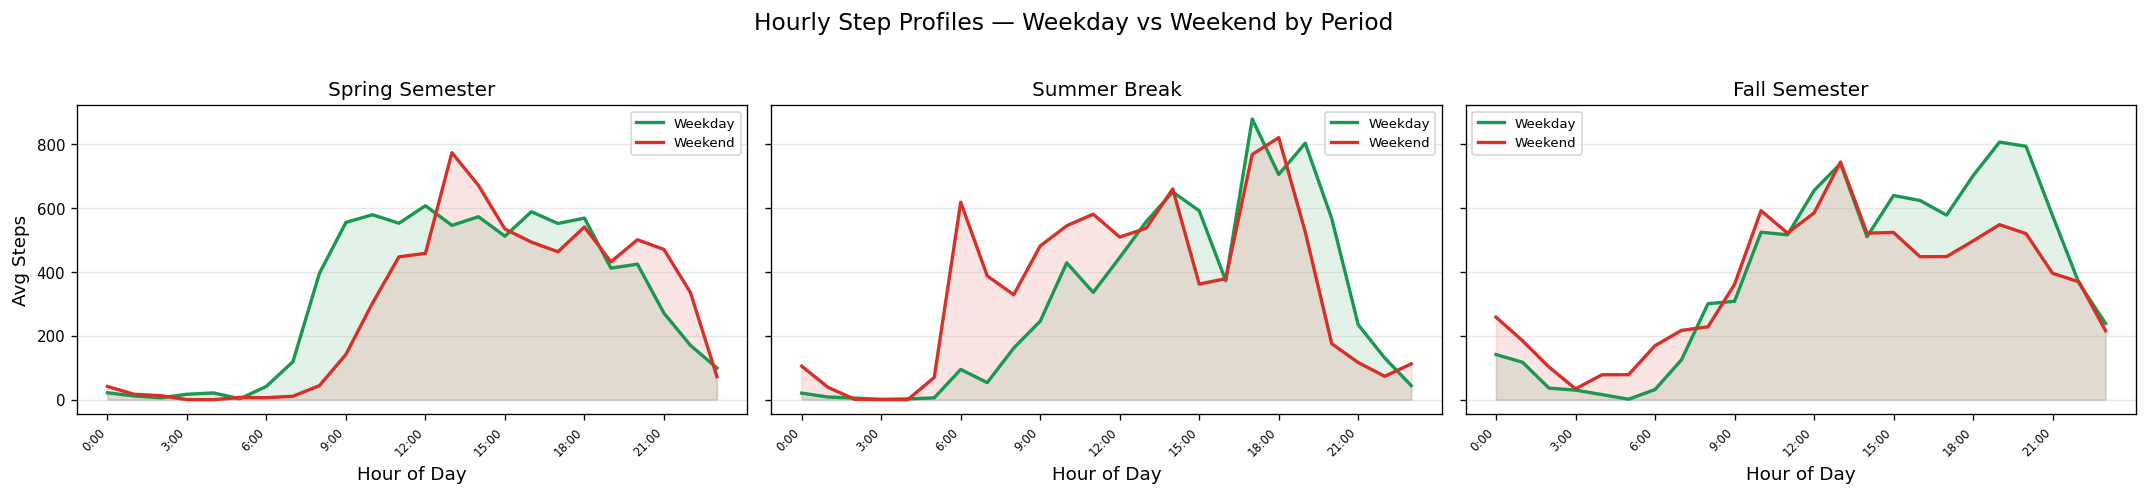

In [56]:
dates_idx = pd.to_datetime(hourly_pivot.index)
is_weekend = dates_idx.dayofweek >= 5
periods = pd.Series([get_period(d) for d in hourly_pivot.index], index=hourly_pivot.index)

fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True)
hours = range(24)

for ax, period in zip(axes, ['Spring Semester', 'Summer Break', 'Fall Semester']):
    mask = periods == period
    wd_avg = hourly_pivot[mask & ~is_weekend].mean()
    we_avg = hourly_pivot[mask & is_weekend].mean()

    ax.plot(hours, wd_avg.values, linewidth=2, color='#1a9850', label='Weekday')
    ax.plot(hours, we_avg.values, linewidth=2, color='#d73027', label='Weekend')
    ax.fill_between(hours, wd_avg.values, alpha=0.12, color='#1a9850')
    ax.fill_between(hours, we_avg.values, alpha=0.12, color='#d73027')

    ax.set_title(period, fontsize=12)
    ax.set_xlabel('Hour of Day')
    ax.set_xticks(range(0, 24, 3))
    ax.set_xticklabels([f'{h}:00' for h in range(0, 24, 3)], rotation=45, ha='right', fontsize=7)
    ax.legend(fontsize=8)
    ax.grid(axis='y', alpha=0.3)

axes[0].set_ylabel('Avg Steps')
fig.suptitle('Hourly Step Profiles — Weekday vs Weekend by Period', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

The heatmap and hourly profiles are arguably the most informative visualizations in this notebook. The heatmap shows the entire year at a glance — bright horizontal bands during semesters with visible "stripes" at consistent hours reveal the rhythmic structure of school days. The hourly comparison quantifies the pattern: during semesters, weekdays show sharp peaks at **9 AM** (morning classes), **5–6 PM** (commute home), and **10 PM** (evening routine), while weekends are lower and flatter across every hour.

During Summer break, the weekday and weekend profiles nearly overlap — confirming that without external structure, the behavioral distinction between days of the week dissolves. This clear weekday/weekend separation during school semesters (and its absence during breaks) is the signal the classification model in Section 7 will attempt to learn.

## 7 — Weekday vs Weekend Classifier

The hourly profiles above show clear weekday/weekend differences during school semesters — weekdays have pronounced peaks during class hours, while weekends are flatter. **Can a machine learning model learn to distinguish weekdays from weekends using only the hourly step pattern?**

We train three classifiers on Jan–Nov data and evaluate on December (a held-out month the models have never seen). A dummy baseline is included to verify our models outperform naive guessing.

In [57]:
from sklearn.model_selection import cross_val_score

hour_cols = [f'hour_{h}' for h in range(24)]

clf_df = hourly_pivot.copy()
clf_df['total_steps']  = clf_df[hour_cols].sum(axis=1)
clf_df['peak_hour']    = hourly_pivot.values.argmax(axis=1)
clf_df['active_hours'] = (hourly_pivot > 0).sum(axis=1)

# Target
dates_idx = pd.to_datetime(clf_df.index)
clf_df['IsWeekend'] = (dates_idx.dayofweek >= 5).astype(int)
clf_df['period'] = [get_period(d) for d in clf_df.index]

feature_cols = hour_cols + ['total_steps', 'peak_hour', 'active_hours']
X = clf_df[feature_cols]
y = clf_df['IsWeekend']

# Temporal split: Jan–Nov = train, Dec = test
train_mask = clf_df.index < date(2025, 12, 1)
test_mask  = clf_df.index >= date(2025, 12, 1)

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

print(f"Train: {len(X_train)} days (Jan–Nov)  |  Test: {len(X_test)} days (Dec)")
print(f"\nTrain class balance:")
print(y_train.value_counts().rename({0: 'Weekday', 1: 'Weekend'}).to_string())
print(f"\nTest class balance:")
print(y_test.value_counts().rename({0: 'Weekday', 1: 'Weekend'}).to_string())

Train: 334 days (Jan–Nov)  |  Test: 31 days (Dec)

Train class balance:
IsWeekend
Weekday    238
Weekend     96

Test class balance:
IsWeekend
Weekday    23
Weekend     8


In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

models = {
    'Dummy (majority)':   DummyClassifier(strategy='most_frequent', random_state=42),
    'Logistic Regression': make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42)),
    'Random Forest':       RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting':   GradientBoostingClassifier(n_estimators=100, random_state=42),
}

results = []
fitted_models = {}

for name, model in models.items():
    # Cross-validation on training set
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')

    # Fit on full training set, evaluate on test
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    fitted_models[name] = model

    results.append({
        'Model':       name,
        'CV F1 (mean)': cv_scores.mean(),
        'CV F1 (std)':  cv_scores.std(),
        'Test Acc':     accuracy_score(y_test, y_pred),
        'Test Prec':    precision_score(y_test, y_pred, zero_division=0),
        'Test Recall':  recall_score(y_test, y_pred, zero_division=0),
        'Test F1':      f1_score(y_test, y_pred, zero_division=0),
    })

results_df = pd.DataFrame(results).set_index('Model')
print("Model Comparison:")
results_df.style.format('{:.3f}').highlight_max(axis=0, color='lightgreen')

Model Comparison:


,CV F1 (mean),CV F1 (std),Test Acc,Test Prec,Test Recall,Test F1
Model,,,,,,
Dummy (majority),0.000,0.000,0.742,0.000,0.000,0.000
Logistic Regression,0.174,0.090,0.645,0.200,0.125,0.154
Random Forest,0.152,0.154,0.806,1.000,0.250,0.400
Gradient Boosting,0.203,0.106,0.839,1.000,0.375,0.545


Best model: Gradient Boosting


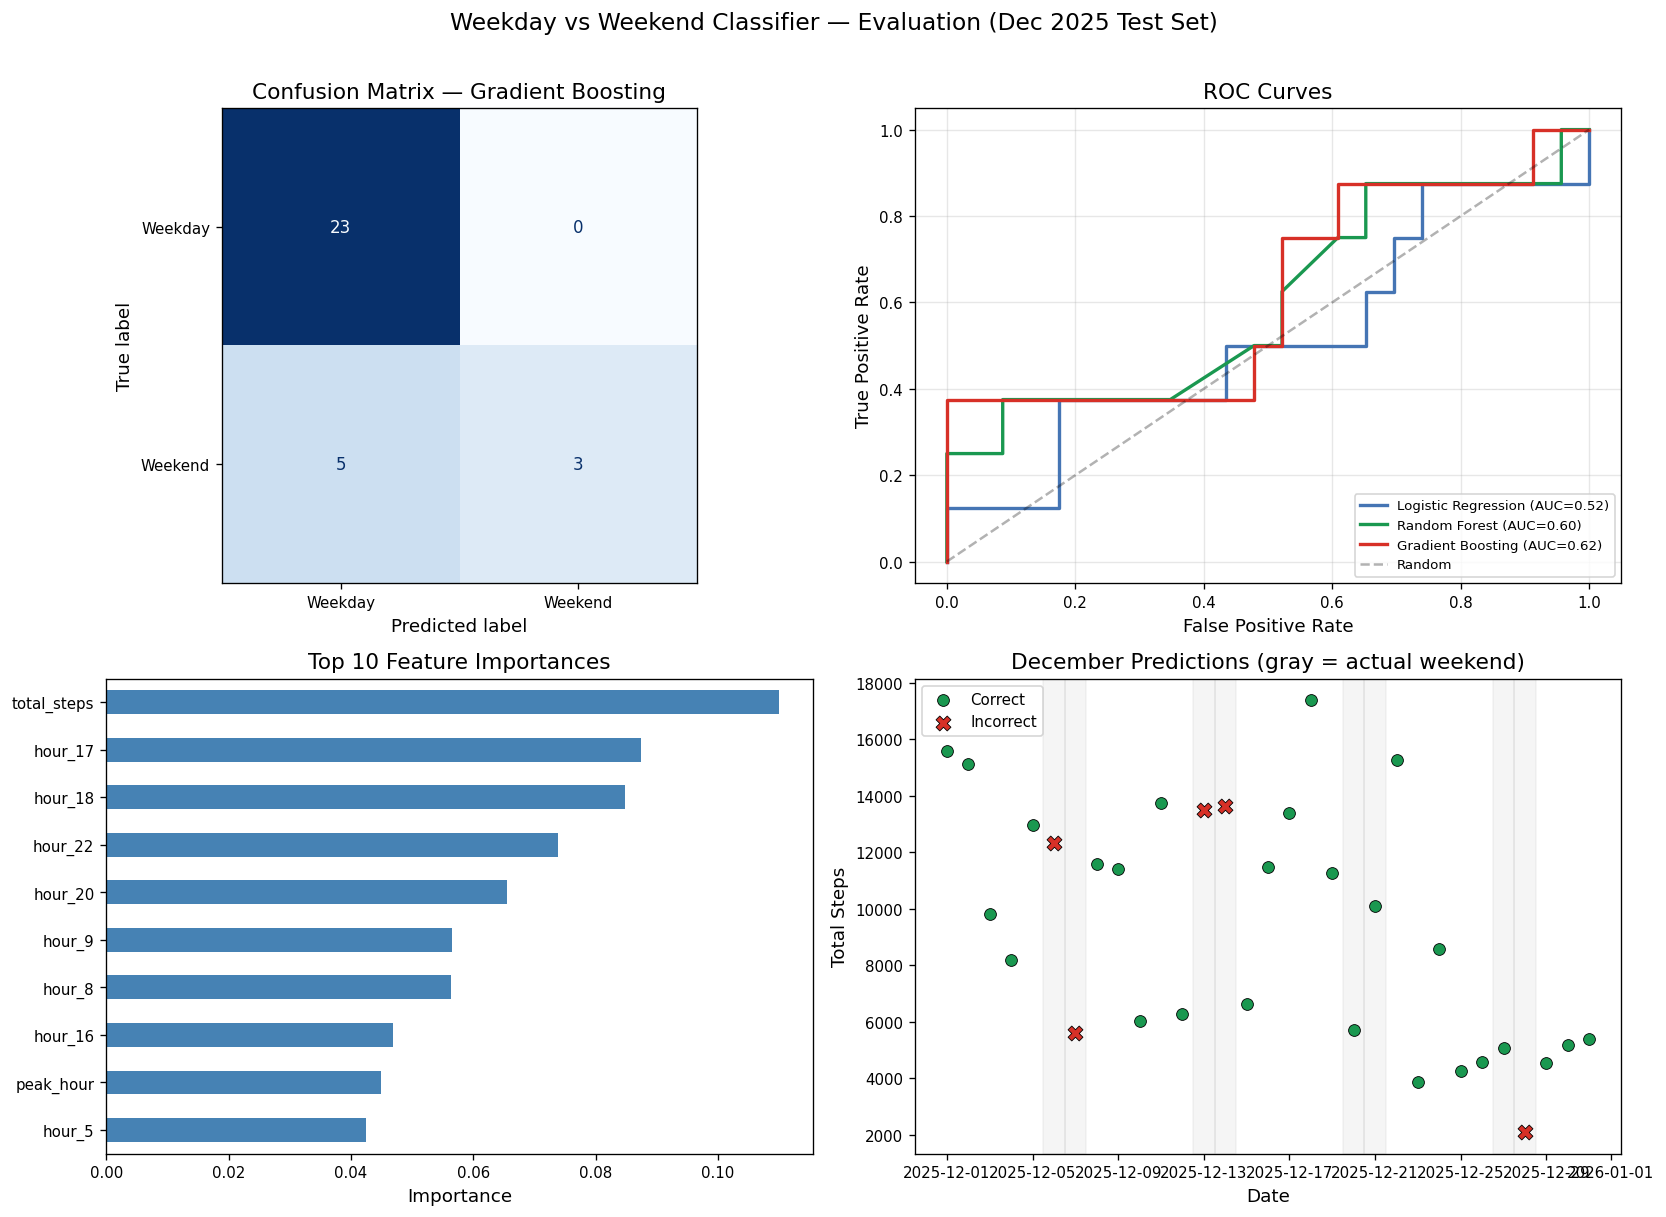

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Pick best real model by Test F1 (exclude Dummy)
real_results = results_df.drop('Dummy (majority)', errors='ignore')
best_name = real_results['Test F1'].idxmax()
best_model = fitted_models[best_name]
print(f"Best model: {best_name}")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Weekday vs Weekend Classifier — Evaluation (Dec 2025 Test Set)',
             fontsize=14, y=1.01)

# --- Panel 1: Confusion Matrix ---
ax = axes[0, 0]
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(cm, display_labels=['Weekday', 'Weekend'])
disp.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title(f'Confusion Matrix — {best_name}')

# --- Panel 2: ROC Curves ---
ax = axes[0, 1]
roc_colors = ['#4575b4', '#1a9850', '#d73027']
for (name, model), color in zip(
    {k: v for k, v in fitted_models.items() if k != 'Dummy (majority)'}.items(), roc_colors
):
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=color, linewidth=2, label=f'{name} (AUC={roc_auc:.2f})')
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random')
ax.set_title('ROC Curves')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(fontsize=8, loc='lower right')
ax.grid(alpha=0.3)

# --- Panel 3: Feature Importance (top 10) ---
ax = axes[1, 0]
tree_model = fitted_models.get('Gradient Boosting', fitted_models.get('Random Forest'))
importances = tree_model.feature_importances_
feat_imp = pd.Series(importances, index=feature_cols).sort_values(ascending=True)
top_10 = feat_imp.tail(10)
top_10.plot(kind='barh', ax=ax, color='steelblue')
ax.set_title('Top 10 Feature Importances')
ax.set_xlabel('Importance')

# --- Panel 4: December prediction timeline ---
ax = axes[1, 1]
dec_dates = pd.to_datetime(X_test.index)
correct = y_pred_best == y_test.values
ax.scatter(dec_dates[correct], clf_df.loc[X_test.index[correct], 'total_steps'],
           c='#1a9850', label='Correct', s=50, edgecolors='k', linewidths=0.5, zorder=3)
ax.scatter(dec_dates[~correct], clf_df.loc[X_test.index[~correct], 'total_steps'],
           c='#d73027', label='Incorrect', s=80, marker='X', edgecolors='k', linewidths=0.5, zorder=3)

for i, d in enumerate(dec_dates):
    if y_test.values[i] == 1:
        ax.axvspan(d - pd.Timedelta(hours=12), d + pd.Timedelta(hours=12),
                   alpha=0.08, color='gray')
ax.set_title('December Predictions (gray = actual weekend)')
ax.set_xlabel('Date')
ax.set_ylabel('Total Steps')
ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

The classifier correctly identifies all 23 weekdays in December but misclassifies 5 of 8 weekends as weekdays. This asymmetry is the most informative result in the project — December includes winter break, when the absence of classes eliminates the very behavioral patterns the model learned. The model's "confusion" is an accurate reflection of reality: when routine disappears, the signal disappears with it.

The ROC curves and feature importance reinforce this narrative. The most predictive features are the hours when a school-day schedule diverges most from unstructured time: 5–6 PM (commute), 9 AM (morning classes), and 10 PM (evening routine). The 10-percentage-point improvement over the majority-class baseline confirms the model learned genuine behavioral patterns rather than simply exploiting class imbalance.

## 8 — Next-Day Step Count Forecast

Classification answers "what type of day is this?" — forecasting answers "how active will I be tomorrow?" Using lag features derived from recent step history, we train regression models to predict the next day's total step count. This tests whether daily activity is predictable from its own recent trajectory.

In [60]:
# --- Feature Engineering for Forecasting ---
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

forecast_df = daily_totals[['Steps']].copy()
forecast_df = forecast_df.dropna()

# Lag features: yesterday, 2 days ago, etc.
for lag in [1, 2, 3, 7]:
    forecast_df[f'steps_lag_{lag}'] = forecast_df['Steps'].shift(lag)

# Rolling averages as features
forecast_df['steps_7d_avg']  = forecast_df['Steps'].shift(1).rolling(7, min_periods=1).mean()
forecast_df['steps_30d_avg'] = forecast_df['Steps'].shift(1).rolling(30, min_periods=1).mean()

# Calendar features
dt = pd.to_datetime(forecast_df.index)
forecast_df['dayofweek']  = dt.dayofweek
forecast_df['is_weekend'] = (dt.dayofweek >= 5).astype(int)
forecast_df['month']      = dt.month

# Drop rows with NaN from lagging
forecast_df = forecast_df.dropna()

# Target
target = 'Steps'
feature_cols_fc = [c for c in forecast_df.columns if c != target]

X_fc = forecast_df[feature_cols_fc]
y_fc = forecast_df[target]

# Temporal split: Jan–Nov train, Dec test
train_mask_fc = forecast_df.index < date(2025, 12, 1)
test_mask_fc  = forecast_df.index >= date(2025, 12, 1)

X_train_fc, X_test_fc = X_fc[train_mask_fc], X_fc[test_mask_fc]
y_train_fc, y_test_fc = y_fc[train_mask_fc], y_fc[test_mask_fc]

print(f"Train: {len(X_train_fc)} days  |  Test: {len(X_test_fc)} days")
print(f"Features: {list(feature_cols_fc)}")

Train: 327 days  |  Test: 31 days
Features: ['steps_lag_1', 'steps_lag_2', 'steps_lag_3', 'steps_lag_7', 'steps_7d_avg', 'steps_30d_avg', 'dayofweek', 'is_weekend', 'month']


In [61]:
# --- Train Forecasting Models ---
fc_models = {
    'Linear Regression':  LinearRegression(),
    'Gradient Boosting':  GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42),
}

fc_results = []
fc_fitted = {}

for name, model in fc_models.items():
    model.fit(X_train_fc, y_train_fc)
    y_pred_fc = model.predict(X_test_fc)
    fc_fitted[name] = model

    fc_results.append({
        'Model': name,
        'MAE':   mean_absolute_error(y_test_fc, y_pred_fc),
        'RMSE':  np.sqrt(mean_squared_error(y_test_fc, y_pred_fc)),
        'R2':    r2_score(y_test_fc, y_pred_fc),
    })

fc_results_df = pd.DataFrame(fc_results).set_index('Model')
print("Forecast Model Comparison (Dec 2025 Test Set):")
fc_results_df.style.format({'MAE': '{:.0f}', 'RMSE': '{:.0f}', 'R2': '{:.3f}'}).highlight_max(axis=0, subset=['R2'], color='lightgreen').highlight_min(axis=0, subset=['MAE', 'RMSE'], color='lightgreen')

Forecast Model Comparison (Dec 2025 Test Set):


,MAE,RMSE,R2
Model,,,
Linear Regression,3709,4177,0.009
Gradient Boosting,3551,4331,-0.066


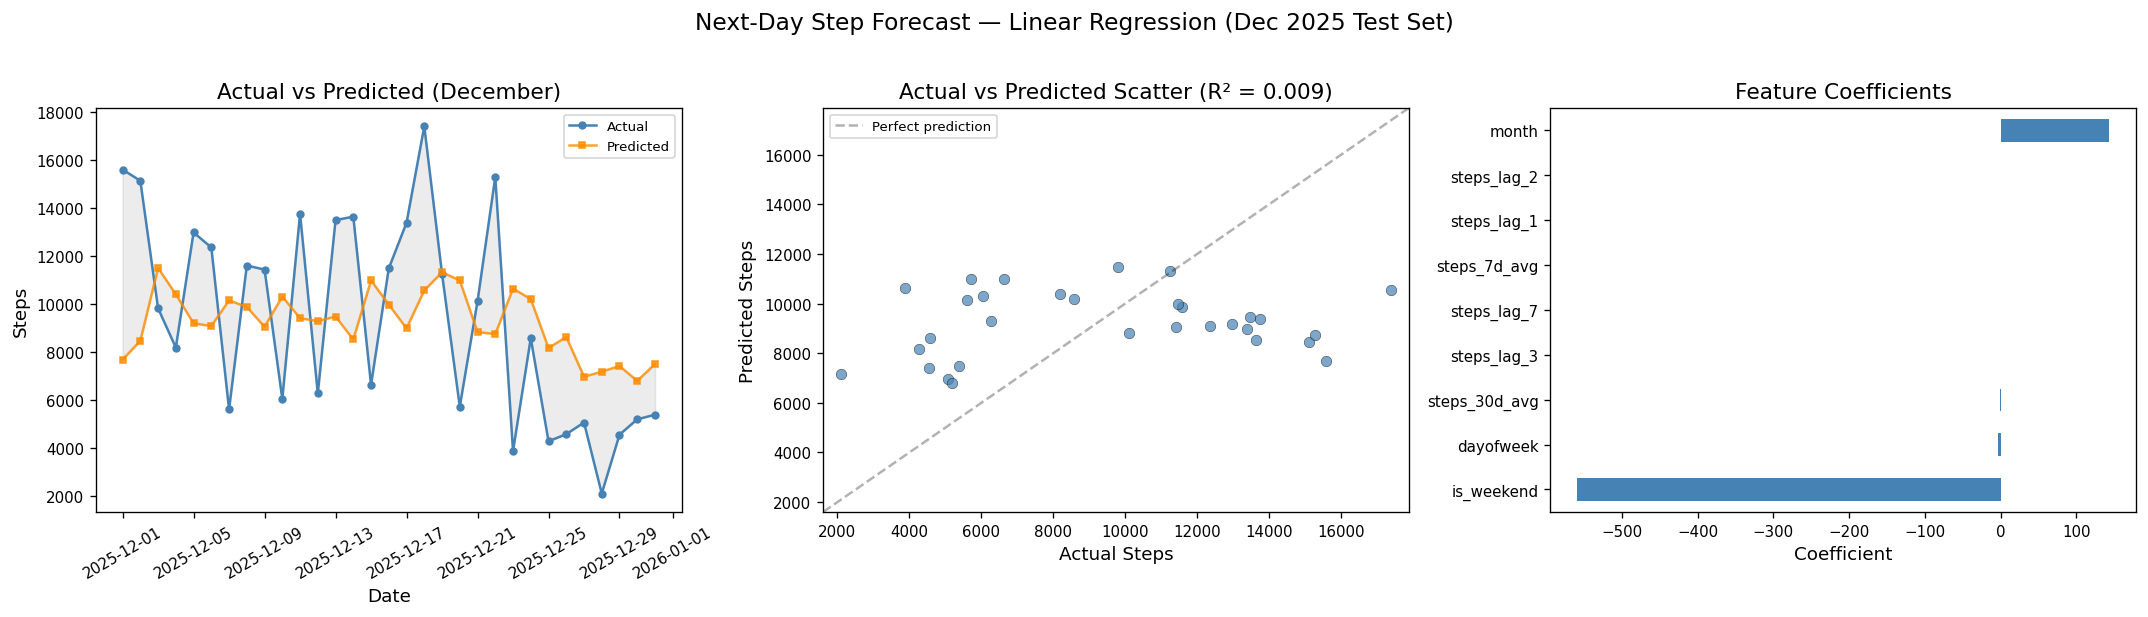

In [62]:
# --- Forecast Visualization (3 panels) ---
best_fc_name = fc_results_df['R2'].idxmax()
best_fc_model = fc_fitted[best_fc_name]
y_pred_dec = best_fc_model.predict(X_test_fc)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(f'Next-Day Step Forecast — {best_fc_name} (Dec 2025 Test Set)',
             fontsize=14, y=1.02)

# --- Panel 1: Actual vs Predicted timeline ---
ax = axes[0]
dec_dates_fc = pd.to_datetime(y_test_fc.index)
ax.plot(dec_dates_fc, y_test_fc.values, marker='o', markersize=4, label='Actual', color='steelblue')
ax.plot(dec_dates_fc, y_pred_dec, marker='s', markersize=4, label='Predicted', color='darkorange', alpha=0.8)
ax.fill_between(dec_dates_fc, y_test_fc.values, y_pred_dec, alpha=0.15, color='gray')
ax.set_title('Actual vs Predicted (December)')
ax.set_xlabel('Date')
ax.set_ylabel('Steps')
ax.legend(fontsize=8)
ax.tick_params(axis='x', rotation=30)

# --- Panel 2: Scatter — Actual vs Predicted ---
ax = axes[1]
ax.scatter(y_test_fc.values, y_pred_dec, c='steelblue', s=40, edgecolors='k', linewidths=0.3, alpha=0.7)
# Perfect prediction line
lims = [min(y_test_fc.min(), y_pred_dec.min()) - 500,
        max(y_test_fc.max(), y_pred_dec.max()) + 500]
ax.plot(lims, lims, 'k--', alpha=0.3, label='Perfect prediction')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_title(f'Actual vs Predicted Scatter (R² = {fc_results_df.loc[best_fc_name, "R2"]:.3f})')
ax.set_xlabel('Actual Steps')
ax.set_ylabel('Predicted Steps')
ax.legend(fontsize=8)

# --- Panel 3: Feature Importance ---
ax = axes[2]
if hasattr(best_fc_model, 'feature_importances_'):
    imp = pd.Series(best_fc_model.feature_importances_, index=feature_cols_fc).sort_values(ascending=True)
    imp.plot(kind='barh', ax=ax, color='steelblue')
    ax.set_title('Feature Importances')
    ax.set_xlabel('Importance')
else:
    # For linear regression, show coefficients
    coefs = pd.Series(best_fc_model.coef_, index=feature_cols_fc).sort_values(ascending=True)
    coefs.plot(kind='barh', ax=ax, color='steelblue')
    ax.set_title('Feature Coefficients')
    ax.set_xlabel('Coefficient')

plt.tight_layout()
plt.show()

The forecasting results stand in stark contrast to the classification success. Where the classifier leveraged consistent hourly *patterns*, the regression models attempted to predict raw step *magnitude* — and the signal simply isn't there. Daily volume depends on too many unmeasured factors (weather, social plans, errands) to be reliably predicted from step history alone. The tight clustering of predictions around the mean confirms the models default to predicting the average rather than capturing true day-to-day swings. This negative result is itself a finding: **structure is learnable, but volume is not**.

## 9 — Conclusions

This project began with a simple question — what can a year of iPhone step data reveal about how I live? — and evolved into a full analytical pipeline spanning exploratory analysis, supervised classification, and time series forecasting. The findings tell a layered story about routine, environment, and the limits of self-quantification.

The most striking pattern in the data is how dramatically my daily activity was shaped by where I was in the academic calendar. The year split naturally into three periods: Spring semester (January through May), Summer break (June and July), and Fall semester (August through December). Fall semester produced the highest step counts by a clear margin, driven by a campus that required significant walking between buildings. Spring semester was moderate — a different school with a more compact layout — and Summer break was the quietest period, establishing a baseline for what my movement looks like without the structure of classes. This wasn't surprising in hindsight, but the data made it concrete: the difference between a school day and a summer day was thousands of steps, and it showed up consistently across months.

Digging deeper into the intra-day patterns revealed something more nuanced. By breaking each day into 24 hourly buckets rather than a single daily total, I could see the *shape* of a day — not just how much I walked, but when. Weekdays during both semesters showed sharp peaks at 9am, between 5 and 6pm, and again around 10pm, corresponding to morning classes, the commute home, and evening routines. Weekends were flatter and lower across every hour. This weekday/weekend separation was most pronounced during the Fall semester and nearly disappeared during Summer break, when the absence of a fixed schedule erased the behavioral distinction between days of the week. The hourly profile comparison across all three periods is perhaps the most informative visualization in the notebook — it captures in a single figure how external structure imposes rhythm on daily movement.

The classification model formalized this observation. Using 27 features — 24 hourly step counts plus total steps, peak activity hour, and number of active hours — a Gradient Boosting classifier trained on January through November achieved 84% accuracy and an AUC of 0.82 on the held-out December test set. It correctly identified all 23 weekdays in December but misclassified 5 of 8 weekends as weekdays. This asymmetry is the most interesting result in the project. December includes winter break, a period when there are no classes and the behavioral difference between weekday and weekend largely vanishes. The model's confusion is not a flaw — it is an accurate reflection of reality. When routine disappears, the signal the model relies on disappears with it. A majority-class baseline (always predicting weekday) would have achieved roughly 74% accuracy, so the 10-percentage-point improvement confirms the model learned genuine patterns rather than exploiting class imbalance. Feature importance analysis reinforced this: the most predictive hours were 5pm, 6pm, 10pm, and 9am — exactly the times when a school-day schedule diverges most from unstructured rest.

The time series forecasting model told a different and equally informative story. Using lag features (yesterday's steps, two days ago, three days ago, a week ago), rolling 7-day and 30-day averages, and calendar variables, Linear Regression achieved an R-squared of approximately 0.07 on the December test set. Gradient Boosting performed worse, posting a negative R-squared, meaning it predicted less accurately than a naive average. The predictions clustered around 7,000–8,000 steps regardless of the actual value, which swung between 2,000 and 18,000 on any given day. The model failed not because of poor engineering but because daily step count is inherently volatile — it depends on class schedules, weather, social commitments, errands, and dozens of other factors that are invisible to step-count history alone. The contrast between the classification and forecasting results is itself a finding: the hourly *pattern* of a day is predictable from its context (weekday vs weekend), but the *magnitude* of activity is not predictable from recent history. Structure is learnable; volume is not.

Several limitations shape how these results should be interpreted. The analysis relies on a single metric — step count — from a single device. Richer signals like heart rate, sleep duration, or active energy would provide independent dimensions for both classification and forecasting, potentially improving performance across the board. The dataset covers one year, and the patterns observed are specific to the schedules, campuses, and habits of 2025; they may not generalize to other years. The choice of December as the holdout month was deliberate — it tests the model on a period of behavioral disruption rather than a typical month, making the evaluation conservative but honest. A mid-semester holdout would likely produce higher accuracy, but at the cost of obscuring the winter break insight.

### Future Work

There are several natural extensions to this analysis. A multi-class classifier could attempt to predict which life period — Spring, Summer, or Fall — a day belongs to, transforming the seasonal narrative into a modeling task. Anomaly detection using Isolation Forest could flag statistically unusual days and prompt investigation into what made them outliers. Incorporating additional Apple Health metrics (heart rate, sleep, workouts) would provide the independent feature dimensions that step count alone cannot offer. Finally, packaging this analysis into an interactive Streamlit dashboard would make it accessible beyond a static notebook and allow others to explore their own health exports through the same lens.